# Schematic diagram of L+S decomposition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter, median_filter
from jupyter_io import savefig_in_notebook
from matplotlib.gridspec import GridSpec

In [2]:
def gaussian(x, mu, sigma):
    return np.exp(-(x-mu)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

def remove_borders(ax):
    for spine in ax.spines.values():
        spine.set_visible(False)

def remove_ticks(ax):
    ax.set_xticks([])
    ax.set_yticks([])

## Common parameters

In [3]:
D = 200
N = 200

f = np.linspace(-1, 1, D)
t = np.arange(N)

## Simulation

### Low-rank matrix (L)

In [4]:
np.random.seed(2020)

gain = -1 * (f-0.75) * (f+0.75) * (f-0.5) * (f+0.5)
atm = 0.01 * uniform_filter(np.cumsum(np.random.randn(N)), int(N/20))

L = gain[:, np.newaxis] + atm
L -= np.max(L) - np.ptp(L) / 2

### Sparse matrix (S)

In [5]:
phi = np.repeat([0, 1, 0, 1, 0, 1, 0], np.ceil(N/7))[:N]
spec = 0.015 * gaussian(f, 0.25, 0.03) + 0.01 * gaussian(f, -0.5, 0.03)

S = -spec[:, np.newaxis] * phi

### Noise matrix (E)

In [6]:
np.random.seed(2020)

E = 0.075 * np.random.randn(D, N)

### Observed matrix (X)

In [7]:
X = L + S + E

## Schematic diagram of L+S decomposition

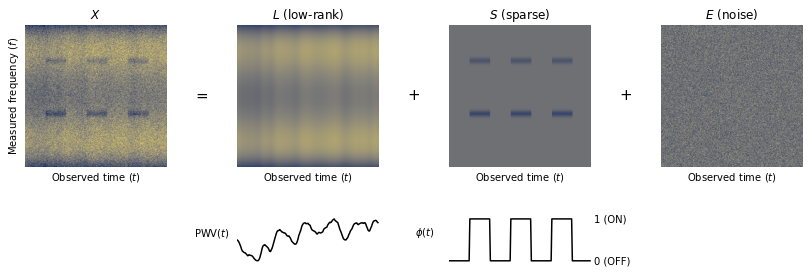

In [8]:
fig = plt.figure(figsize=(12, 4))
grid = GridSpec(2, 4, height_ratios=[4, 1], left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.25, wspace=0.5)
cmap = "cividis"

ax = fig.add_subplot(grid[0, 0])
im = ax.imshow(X, cmap=cmap)
ax.set_title(r"$X$")
ax.set_xlabel(r"Observed time ($t$)")
ax.set_ylabel(r"Measured frequency ($f$)")
remove_borders(ax)
remove_ticks(ax)

ax = fig.add_subplot(grid[0, 1])
ax.imshow(L, clim=im.get_clim(), cmap=cmap)
ax.set_title(r"$L$ (low-rank)")
ax.set_xlabel(r"Observed time ($t$)")
ax.annotate("=", (-0.25, 0.5), xycoords=ax, size=15, ha="center", va="center")
remove_borders(ax)
remove_ticks(ax)

ax = fig.add_subplot(grid[0, 2])
ax.imshow(S, clim=im.get_clim(), cmap=cmap)
ax.set_title(r"$S$ (sparse)")
ax.set_xlabel(r"Observed time ($t$)")
ax.annotate("+", (-0.25, 0.5), xycoords=ax, size=15, ha="center", va="center")
remove_borders(ax)
remove_ticks(ax)

ax = fig.add_subplot(grid[0, 3])
ax.imshow(E, clim=im.get_clim(), cmap=cmap)
ax.set_title(r"$E$ (noise)")
ax.set_xlabel(r"Observed time ($t$)")
ax.annotate("+", (-0.25, 0.5), xycoords=ax, size=15, ha="center", va="center")
remove_borders(ax)
remove_ticks(ax)

ax = fig.add_subplot(grid[1, 1])
ax.plot(t, atm, color="black")
ax.set_xlim(0, 200)
ax.set_ylabel(r"$\mathrm{PWV}(t)$", rotation=0, labelpad=25)
remove_borders(ax)
remove_ticks(ax)

ax = fig.add_subplot(grid[1, 2])
ax.yaxis.tick_right()
ax.plot(t, phi, color="black")
ax.set_xlim(0, 200)
ax.set_ylabel(r"$\phi(t)$", rotation=0, labelpad=25)
ax.set_xticks([])
ax.set_yticks([0, 1])
ax.tick_params(length=0)
ax.set_yticklabels(["0 (OFF)", "1 (ON)"])
remove_borders(ax)

savefig_in_notebook(fig, "lowrank-sparse-decomposition.pdf")

## Schematic diagram of algorithm

In [9]:
k = 30
w = 7

S_est = X - L
s_est = (S_est * phi).sum(1) / phi.sum()
psi = np.zeros_like(s_est)
psi[np.argsort(s_est)[:k]] = 1

s_est_filtered = median_filter(s_est, w)
psi_filtered = np.zeros_like(s_est_filtered)
psi_filtered[np.argsort(s_est_filtered)[:k]] = 1

Omega = phi * psi_filtered[:, np.newaxis]

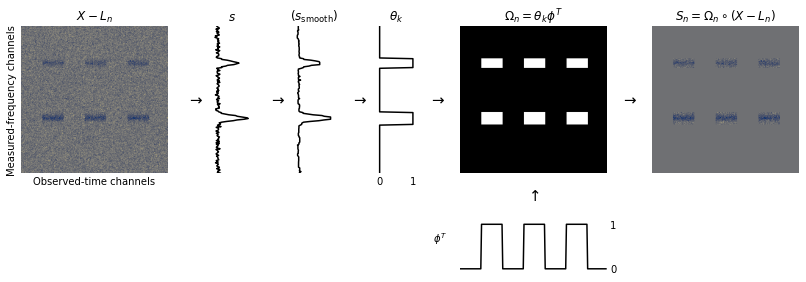

In [10]:
fig = plt.figure(figsize=(12, 4))
grid = GridSpec(2, 6, width_ratios=[4, 1, 1, 1, 4, 4], height_ratios=[3, 1],
                left=0.05, right=0.95, top=0.90, bottom=0.05, hspace=0.5, wspace=0.5)
cmap = "cividis"

ax = fig.add_subplot(grid[0, 0])
ax.imshow(X-L, clim=im.get_clim(), cmap=cmap)
ax.set_title(r"$X-L_{n}$")
ax.set_xlabel(r"Observed-time channels")
ax.set_ylabel("Measured-frequency channels")
remove_borders(ax)
remove_ticks(ax)

ax = fig.add_subplot(grid[0, 1])
ax.plot(-s_est, -f, color="black")
ax.set_ylim(-1, 1)
ax.set_title(r"$s$")
ax.annotate(r"$\rightarrow$", (-0.5, 0.5), xycoords=ax, size=15, ha="center", va="center")
remove_borders(ax)
remove_ticks(ax)

ax = fig.add_subplot(grid[0, 2])
ax.plot(-s_est_filtered, -f, color="black")
ax.set_ylim(-1, 1)
ax.set_title(r"($s_{\mathrm{smooth}}$)")
ax.annotate(r"$\rightarrow$", (-0.5, 0.5), xycoords=ax, size=15, ha="center", va="center")
remove_borders(ax)
remove_ticks(ax)

ax = fig.add_subplot(grid[0, 3])
ax.plot(psi_filtered, -f, color="black")
ax.set_ylim(-1, 1)
ax.set_title(r"$\theta_{k}$")
ax.annotate(r"$\rightarrow$", (-0.5, 0.5), xycoords=ax, size=15, ha="center", va="center")
ax.set_xticks([0, 1])
ax.set_yticks([])
ax.tick_params(length=0)
ax.set_xticklabels(["0", "1"])
remove_borders(ax)

ax = fig.add_subplot(grid[0, 4])
ax.imshow(Omega, cmap="binary_r")
ax.set_title(r"$\Omega_{n} = \theta_{k} \phi^{T}$")
ax.annotate(r"$\rightarrow$", (-0.16, 0.5), xycoords=ax, size=15, ha="center", va="center")
ax.annotate(r"$\uparrow$", (0.5, -0.16), xycoords=ax, size=15, ha="center", va="center", zorder=-100)
remove_borders(ax)
remove_ticks(ax)

ax = fig.add_subplot(grid[0, 5])
ax.imshow(Omega*(X-L), clim=im.get_clim(), cmap=cmap)
ax.set_title(r"$S_{n} = \Omega_{n} \circ (X-L_{n})$")
ax.annotate(r"$\rightarrow$", (-0.16, 0.5), xycoords=ax, size=15, ha="center", va="center")
remove_borders(ax)
remove_ticks(ax)

ax = fig.add_subplot(grid[1, 4], sharex=ax)
ax.yaxis.tick_right()
ax.plot(t, phi, color="black")
ax.set_xlim(0, 200)
ax.set_ylabel(r"$\phi^{T}$", rotation=0, labelpad=20)
ax.set_xticks([])
ax.set_yticks([0, 1])
ax.tick_params(length=0)
ax.set_yticklabels(["0", "1"])
remove_borders(ax)

savefig_in_notebook(fig, "sparseid-for-fast-sampled-position-switch-observations.pdf")